# Preprocessor

In [280]:
# TODO: remove one word lines. But you alraedy do remove all pos under 3 words, so might as well do that for negative and neutral.


In [301]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle

import re
import emoji
import numpy as np
from nltk.tokenize.casual import EMOTICON_RE

from tqdm import tqdm
#nltk.download('wordnet')
#nltk.download('words')
from nltk.sentiment.util import mark_negation
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

from collections import Counter
from wordcloud import WordCloud
from nltk import FreqDist
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

DATASET_COLUMNS = ['Id', 'Review', 'Sentiment']
senti_labels = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_categories = list(senti_labels.values())
NUM_of_CLASSES = 3


pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 50) 
input_folder_path = "./pls/Thesis_Jupyter_Final/src/input/"
processed_folder_path = "./pls/Thesis_Jupyter_Final/src/input/processed"
contraction_mapping = {
            "isn't": "is not",
            "aren't": "are not",
            "don't": "do not",
            "doesn't": "does not",
            "wasn't": "was not",
            "weren't": "were not",
            "didn't": "did not",
            "haven't": "have not",
            "hasn't": "has not",
            "hadn't": "had not",
            "won't": "will not",
            "can't": "cannot",
            "couldn't": "could not",
            "shouldn't": "should not",
            "wouldn't": "would not",
            "mightn't": "might not",
            "mustn't": "must not",
            }
emojis = [
    # HAPPY
    ":-)", ":)", ";)", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)",
    "=)", ":}", ":^)", ":-D", ":D", "8-D", "8D", "x-D", "xD", "X-D",
    "XD", "=-D", "=D", "=-3", "=3", ":-))", ":'-)", ":')", ":*", ":^*",
    ">:P", ":-P", ":P", "X-P", "x-p", "xp", "XP", ":-p", ":p", "=p",
    ":-b", ":b", ">:)", ">;)", ">:-)", "<3",

    # SAD
    ":L", ":-/", ">:/", ":S", ">:[", ":@", ":-(", ":[", ":-||", "=L", 
    ":<", ":-[", ":-<", "=\\", "=/", ">:(", ":(", ">.<", ":'-(", ":'(",
    ":\\", ":-c", ":c", ":{", ">:\\", ";("
]

Goal of project: 

This notebook includes: (steps)

# Load Data

First, we load and explore the dataset and apply some initial processing such as setting the '*Id*' column as index and removing any empty rows.

In [282]:
def drop_missing(data):
    # Remove any rows with missing values and reset the index
    rows_before = data.shape[0] 

    data.replace('', np.nan, inplace=True)
    data = data.dropna()
    data.reset_index(drop=True, inplace=True)

    rows_after = data.shape[0]
    # Count the number of rows removed
    print(f"Number of removed rows: {rows_before - rows_after}")

    return data

In [283]:
def load_data(filename, process=True):
    # Load data
    data_file_path = os.path.join(input_folder_path, filename)
    df = pd.read_csv(data_file_path)

    if process:
        # Set ID as index
        df.set_index('Id', inplace=True, drop=True)
        df = drop_missing(df)

        print(df.info())
        print()
        print(f'Dataset shape: {df.shape}\n')

    return df

data_filename = "original_data.csv"
df_original = load_data(data_filename)

Number of removed rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     107018 non-null  object
 1   Sentiment  107018 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None

Dataset shape: (107018, 2)



In [284]:
df_original.head(20)

,Review,Sentiment
0,good and interesting,3
1,"This class is very helpful to me. Currently, I'm still learning this class which makes up a lot of basic music knowledge.",3
2,like!Prof and TAs are helpful and the discussion among students are quite active. Very rewarding learning experience!,3
3,Easy to follow and includes a lot basic and important techniques to use sketchup.,3
4,Really nice teacher!I could got the point eazliy but the v,3
5,"Great course - I recommend it for all, especially IT and Business Managers!",3
6,One of the most useful course on IT Management!,3
7,"I was disappointed because the name is misleading. The course provides a good introduction & overview of the responsibilities of the CTO, but has very little specifically digital content. It deals with two-speed IT in a single short lecture, so of course the treatment is superficial. It is easy ...",2
8,Super content. I'll definitely re-do the course,3
9,One of the excellent courses at Coursera for information technology bosses and managers.,3


### Analysing Data (TODO)
We then analyse the dataset by observing the distribution of review per sentiment.

In [285]:
def print_senti_counts(counts):
    # Print the number of reviews per sentiment 
    for senti, count in counts.items():
        sentiment_name = senti_labels[senti]
        print(f"{senti} ({sentiment_name}): {count} reviews")

def plot_senti_counts(counts):
    # Plot counts per sentiment
    colors = ['limegreen', 'dodgerblue', 'red']
    plt.pie(counts, colors=colors, autopct='%1.1f%%',  pctdistance=0.8, textprops={'fontsize': 10, 'color': 'black'}, startangle=90)
    plt.axis('equal')  # pie as a circle
    plt.legend(labels=senti_categories[::-1], loc='lower left')
    plt.title('Distribution of Reviews per Sentiment')
    plt.show()

def count_words(text):
    # Count words per review
    return len(str(text).split(' '))

3 (Positive): 97227 reviews
2 (Neutral): 5071 reviews
1 (Negative): 4720 reviews


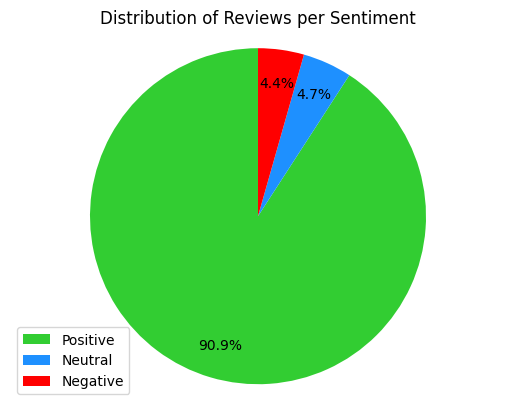

Total word count:  2661665
Average review length: 24.87


In [286]:
def analyse_data(df):
    # Call all the data analysis functions at once
    senti_counts = df['Sentiment'].value_counts()
    print_senti_counts(senti_counts)
    plot_senti_counts(senti_counts)

    # Calculate total and average word count without adding a new column to the dataframe
    total_word_count = df['Review'].apply(count_words).sum()
    avg_review_len = df['Review'].apply(count_words).mean()

    print("Total word count: ", total_word_count)
    print(f"Average review length: {avg_review_len:.2f}")


analyse_data(df_original)

## Clean Text

Next, we clean the data applying the following techniques (TODO: add info):

In [287]:
def clean_data(df):
    # 1) Lowercase
    df['Review'] = df['Review'].str.lower()

    # 2) Replace contractions with their standard full forms
    for contraction, standard in contraction_mapping.items():
        df['Review'] = df['Review'].str.replace(contraction, standard)

    
    # 3) Remove punctuation in between words e.g. "course.sometimes", "i'll" and replace with space
    pattern = r'(?<=\w)[^\w\s]+(?=\w)'
    df['Review'] = df['Review'].str.replace(pattern, ' ', regex=True)
    df['Review'] = df['Review'].str.replace('...', '', regex=False)

    print("3")

    # 4) Tokenize text into individual words (removes all extra spaces \s)
    tokenizer = TweetTokenizer()
    df['Review'] = df['Review'].apply(tokenizer.tokenize)

    # 5) Remove punctuation first in between words (typo), and then all punctuation and numerals except for tokenized emojis
    pattern = r"[^\w\s" + "".join(re.escape(e) for e in emojis + list(emoji.EMOJI_DATA.keys())) + "]|[\d]+" # match non-emoji special characters
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if not re.match(pattern, token)])

    # 6) Remove single characters
    df['Review'] = df['Review'].apply(lambda tokens: [word for word in tokens if len(word) > 1])

    print("6")

    # 8) Perform negation tagging
    df['Review'] = df['Review'].apply(mark_negation)

    # 9) Remove stopwords --> also removes words like 'not'
    stop_words = set(stopwords.words('english'))
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token.split('_')[0] not in stop_words])

     # 10) Lemmatize words using WordNetLemmatizer (also lemmatizes words removing _NEG)
    def lemmatize_token(token):
        lemmatizer = WordNetLemmatizer()
        if "_NEG" in token:
            word, tag = token.split("_NEG")
            return lemmatizer.lemmatize(word) + "_NEG"
        else:
            return lemmatizer.lemmatize(token)
        
    print("10")

    df['Review'] = df['Review'].apply(lambda tokens: [lemmatize_token(token) for token in tokens])

    # Convert preprocessed tokens back to string
    df['Review'] = df['Review'].apply(' '.join)

    return df


# Create a copy of the original DataFrame to preserve the original data
df_clean = df_original.copy()
# Apply preprocessing
df_clean = clean_data(df_clean) 
# Remove NaN rows, after cleaning text
df_clean = drop_missing(df_clean) 
print(f'Dataset shape (after text cleaning): {df_clean.shape}\n')

3
6
10
Number of removed rows: 31
Dataset shape (after text cleaning): (106987, 2)



In [288]:
df_clean.head(20)

,Review,Sentiment
0,good interesting,3
1,class helpful currently still learning class make lot basic music knowledge,3
2,like prof ta helpful discussion among student quite active rewarding learning experience,3
3,easy follow includes lot basic important technique use sketchup,3
4,really nice teacher could got point eazliy,3
5,great course recommend especially business manager,3
6,one useful course management,3
7,disappointed name misleading course provides good introduction overview responsibility cto little specifically digital content deal two speed single short lecture course treatment superficial easy find depth material freely available mckinsey website example,2
8,super content definitely course,3
9,one excellent course coursera information technology boss manager,3


In [289]:
# TODO: check if spellchecker words in tests

In [290]:
def save_data(df):
    data_file_path = os.path.join(input_folder_path, clean_data_filename)
    df.to_csv(data_file_path, sep=',', index_label='Id')

clean_data_filename = "clean_data.csv"
save_data(df_clean)

# Preprocess Data

First we load cleaned data.

In [313]:
clean_data_filename = "clean_data.csv"
loaded_clean_df = load_data(clean_data_filename, process=False)

### Split train and test

In [314]:
def split_train_test(review_col, sentiment_col):
    # Split dataset into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(review_col, sentiment_col, test_size=0.2, random_state=42)
    # Split the training dataset further into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))

    return x_train, y_train, x_val, y_val, x_test, y_test


x_train, y_train, x_val, y_val, x_test, y_test = split_train_test(loaded_clean_df['Review'], loaded_clean_df['Sentiment'])

Data Distribution:
* train: 68471
* validation: 17118
* test: 21398



In [315]:
x_train.head(100)

73868     plan purchase course enjoy course really_NEG f...
78926     good introductory course descriptive statistic...
97645     great experience developed efficiently provide...
64107                              clear enlightening thank
61156     detailed informing learned whole lot course co...
74081     good course beginner prof chuck humour explain...
75010                                    easy good beginner
20168     good content exercise pedagogic problem use pr...
25796                                                 loved
103630                                 course could content
79473                      wrong subtitle communication_NEG
38363          really informed importance rock roll history
41951                might right tool shine mind excellence
51971     great course easy follow fun visuals proper te...
73942                                  good course beginner
27452                       really_NEG enjoy_NEG course_NEG
50508     great course building refreshi

### Create & Analyse Vocabulary

### Analysis Functions

In [316]:
def plot_word_freq_cdf(word_counts, min_cutoff, max_cutoff):
    # Calculate the cumulative sum of the sorted frequencies & normalize
    cumu_counts = np.cumsum(word_counts)
    cdf = cumu_counts / cumu_counts[-1]

    # Plot the CDF
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(1, len(cdf) + 1), cdf)
    plt.axvline(x=min_cutoff, color='r', linestyle='--')
    plt.axvline(x=max_cutoff, color='r', linestyle='--')
    plt.xlabel('Word Rank')
    plt.ylabel('Cumulative Frequency')
    plt.title('CDF of Word Frequencies')
    plt.grid(True)
    plt.show()

def calculate_word_statistics(freqs):

    print("Mean frequency: ", np.mean(freqs))
    print("Median frequency: ", np.median(freqs))
    print("Max frequency: ", max(freqs))
    print("Min frequency: ", min(freqs))
    print("Standard deviation: ", np.std(freqs))
    print("1st quartile: ", np.percentile(freqs, 25))
    print("3rd quartile: ", np.percentile(freqs, 75))

def create_wordcloud(word_counts):
    wordcloud = WordCloud().generate_from_frequencies(word_counts)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def plot_word_freq_most_common(dataset, num_most_common=60):
    all_words = [word for review in dataset for word in review.split()]

    fdist = FreqDist(all_words)
    plt.figure(figsize=(10, 5))
    fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens')
    plt.show()

def plot_word_freq_hist(word_counts):
    # Set up a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot word frequency distribution with linear scale
    ax1.hist(word_counts, bins=range(1, 50), alpha=0.5)
    ax1.set_title('Word Frequency Distribution (Linear Scale)')
    ax1.set_xlabel('Word Frequency')
    ax1.set_ylabel('Number of Words')

    # Plot word frequency distribution with logarithmic scale
    ax2.hist(word_counts, bins=range(1, 500, 10), alpha=0.5)
    ax2.set_yscale('log')
    ax2.set_title('Word Frequency Distribution (Logarithmic Scale)')
    ax2.set_xlabel('Word Frequency')
    ax2.set_ylabel('Number of Words')

50 Most common words: [('course', 50168), ('great', 15653), ('good', 12272), ('really', 7852), ('course_NEG', 7370), ('well', 6380), ('lot', 6284), ('learning', 6196), ('excellent', 5844), ('interesting', 5194), ('thank', 4766), ('learn', 4595), ('useful', 4048), ('would', 4013), ('easy', 3947), ('much', 3928), ('material', 3832), ('way', 3663), ('assignment', 3616), ('one', 3571), ('thanks', 3568), ('understand', 3467), ('basic', 3396), ('like', 3375), ('lecture', 3229), ('content', 3145), ('video', 3130), ('class', 3124), ('professor', 3055), ('concept', 3007), ('introduction', 2989), ('best', 2971), ('learned', 2953), ('time', 2893), ('teacher', 2859), ('helpful', 2800), ('recommend', 2757), ('information', 2668), ('programming', 2473), ('knowledge', 2470), ('nice', 2461), ('enjoyed', 2398), ('clear', 2392), ('work', 2381), ('also', 2304), ('instructor', 2253), ('make', 2209), ('get', 2204), ('help', 2196), ('topic', 2191)]
Unfiltered vocab size: 31957

Mean frequency:  28.472603811

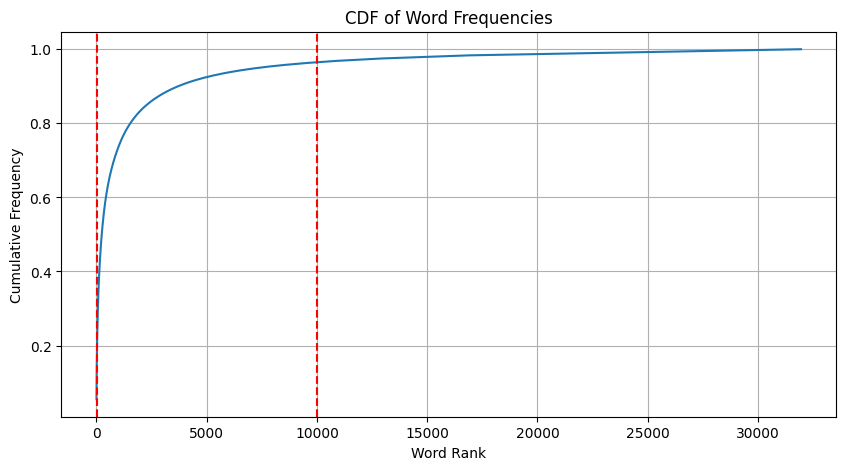

Min Freq: 4
Max Freq: 3571

Vocabulary size of 31957 reduced to 10635.

Vocabulary (first 20):
plan, purchase, enjoy, really_NEG, free_NEG, watch_NEG, lecture_NEG, must_NEG, pay_NEG, unlock_NEG, python_NEG, real_NEG, point_NEG, cannot_NEG, test_NEG, knowledge_NEG, introductory, descriptive, statistic, probability

Mean frequency:  67.79059708509638
Median frequency:  12.0
Max frequency:  3571
Min frequency:  4
Standard deviation:  227.01597272459256
1st quartile:  6.0
3rd quartile:  37.0


Stored 'vocab' (dict)
Stored 'vocab_size' (int)


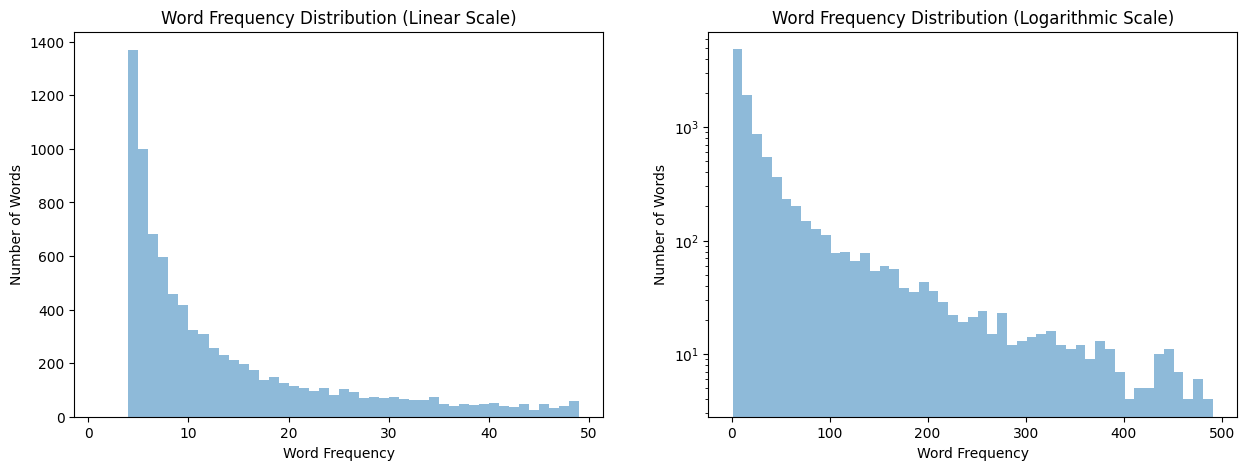

In [317]:
def create_vocab(data, min_cutoff, max_cutoff):
    # Calculate frequency of words in the training set
    word_freqs = Counter()
    for review in data:
        word_freqs.update(review.split())
    print(f"50 Most common words: {word_freqs.most_common(50)}")
    print(f"Unfiltered vocab size: { len(word_freqs)}\n")
    freqs = np.array(list(word_freqs.values()))
    calculate_word_statistics(freqs)

    # Calculate cdf
    counts = np.array(list(word_freqs.values()))
    counts_sorted = np.sort(counts)[::-1] # descending
    plot_word_freq_cdf(counts_sorted, min_cutoff, max_cutoff)

    # Convert the cutoff values in terms of rank to the actual frequency values
    min_freq = counts_sorted[MAX_RANK_CUTOFF - 1]  # -1 since 0-based indexing
    max_freq = counts_sorted[MIN_RANK_CUTOFF - 1]  
    print(f"Min Freq: {min_freq}\nMax Freq: {max_freq}\n")

    # Filter vocabulary by removing words with frequency less than a set minimum frequency
    vocab = {token: freq for token, freq in word_freqs.items() if min_freq <= freq <= max_freq}
    vocab_size = len(vocab)
    print(f"Vocabulary size of {len(word_freqs)} reduced to {vocab_size}.\n")
    vocab_list = ', '.join(list(vocab.keys())[:20])
    print(f"Vocabulary (first 20):\n{vocab_list}\n")

    # Recalculate word statistics and plot word frequency using the filtered vocabulary
    freqs = np.array(list(vocab.values()))
    calculate_word_statistics(freqs)
    plot_word_freq_hist(freqs)
    #create_wordcloud(vocab)

    # Create the folder if it doesn't exist
    if not os.path.exists(processed_folder_path):
        os.makedirs(processed_folder_path)

    # Save vocab
    vocab_data_filename = "vocab.txt"
    file_path = os.path.join(processed_folder_path, vocab_data_filename)
    with open(file_path, 'w') as file:
        file.write("\n".join(vocab))

    return vocab, vocab_size


# PROCESSING-CONSTANTS
MIN_RANK_CUTOFF = 20
MAX_RANK_CUTOFF = 10000

vocab, vocab_size = create_vocab(x_train, MIN_RANK_CUTOFF, MAX_RANK_CUTOFF)

%store vocab
%store vocab_size

#### Filter data with vocabulary

73868     plan purchase course enjoy course really_NEG f...
78926     good introductory course descriptive statistic...
97645     great experience developed efficiently provide...
64107                              clear enlightening thank
61156     detailed informing learned whole lot course co...
74081     good course beginner prof chuck humour explain...
75010                                    easy good beginner
20168     good content exercise pedagogic problem use pr...
25796                                                 loved
103630                                 course could content
79473                      wrong subtitle communication_NEG
38363          really informed importance rock roll history
41951                might right tool shine mind excellence
51971     great course easy follow fun visuals proper te...
73942                                  good course beginner
27452                       really_NEG enjoy_NEG course_NEG
50508     great course building refreshi

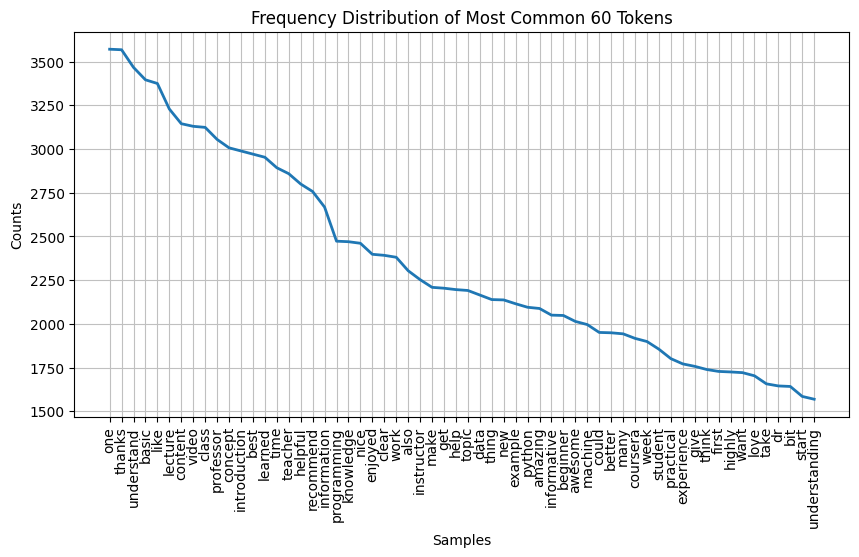

Data Distribution:
* train: 64974
* validation: 16246
* test: 20338



In [319]:
def drop_empty_rows(x, y):
    # Merge x and y datasets and drop empty rows
    merged = pd.concat([x, y], axis=1)
    merged.columns = ['x', 'y']
    
    merged.replace('', np.nan, inplace=True)
    merged.dropna(subset=['x'], inplace=True) # TODO: subset?

    # Re-assign X and Y datasets
    x_filtered = merged['x']
    y_filtered = merged['y']

    return x_filtered, y_filtered

def freq_filter_dataset(x, y, vocab):
    filtered_x = []
    for review in x:
        filtered_text = ' '.join([word for word in review.split() if word in vocab])
        filtered_x.append(filtered_text)

    filtered_x = pd.Series(filtered_x, index=x.index)

    print(filtered_x[:20])

    with open("x_filt.txt", "w") as f:
        for item in filtered_x:
            f.write("%s\n" % item)

    x_filt, y_filt = drop_empty_rows(filtered_x, y)
    
    return x_filt, y_filt

# Filter dataset based on vocabulary
print(x_train[:20])
print()
x_train, y_train = freq_filter_dataset(x_train, y_train, vocab)
x_val, y_val = freq_filter_dataset(x_val, y_val, vocab)
x_test, y_test = freq_filter_dataset(x_test, y_val, vocab)
plot_word_freq_most_common(x_train, num_most_common=60)

print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))

with open("x_empty.txt", "w") as f:
        for item in x_train:
            f.write("%s\n" % item)


In [ ]:
# TODO: !!! left here

In [ ]:
senti_counts = y_train.value_counts()
print_senti_counts(senti_counts)

3 (Positive): 58713 reviews
2 (Neutral): 3224 reviews
1 (Negative): 3037 reviews


# Balance Data

We remove positive reviews that have 3 words or less...

In [ ]:
condition = ~((df['Sentiment'] == 3) & (df['Review'].apply(count_words) < 3))
df = df[condition]

In [ ]:
print(f"Dataset length reduced from {df_raw.shape[0]} to {df.shape[0]}.")

NameError: name 'df_raw' is not defined

In [ ]:
# The "strategy" parameter can take a dict, callable, or str as input
# You might need to adjust these parameters according to the distribution of your classes
over_strategy = {1: 5000, 2: 5000} # Over-sample minority classes 10000
under_strategy = {3: 10000} # Under-sample majority classes 40000

# Define pipeline
over = RandomOverSampler(sampling_strategy=over_strategy)
under = RandomUnderSampler(sampling_strategy=under_strategy)
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Applying the balancing pipeline to both x and y datasets
x_balanced, y_balanced = pipeline.fit_resample(pd.DataFrame(x_train), y_train)

# Print out the new class distribution
counter = Counter(y_balanced)
print(counter)

x_train = x_balanced.copy()
y_train = y_balanced.copy()


Counter({3: 10000, 1: 5000, 2: 5000})


In [ ]:
print(x_train.shape, y_train.shape)
print(x_train[:5])

(60000, 1) (60000,)
                               x
0  topic interest however con...
1          really_NEG course_NEG
2  information going fast fee...
3  fast pace make_NEG online_...
4  would recommend_NEG one_NE...


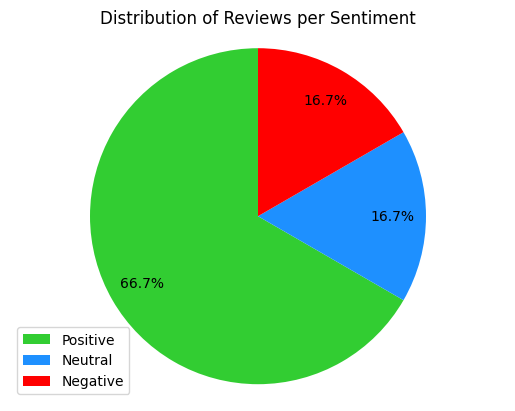

Total word count:  150
Average review length: 150.00


In [ ]:
# Print balanced shape of training data
senti_counts = y_train.value_counts()
plot_senti_counts(senti_counts)

total_word_count = x_train.apply(count_words).sum()
avg_review_len = x_train.apply(count_words).mean()

print("Total word count: ", total_word_count)
print(f"Average review length: {avg_review_len:.2f}")

In [ ]:
def save_data(x, y, filename):
    # Save filtered dataset to a csv file

    # Merge X and Y datasets
    merged_df = pd.concat([x, y], axis=1)
    merged_df.columns = ['x', 'y']
    file_path = os.path.join(input_folder_path, filename)
    merged_df.to_csv(file_path, sep=',', index_label='Id')

save_data(x_train, y_train, "train.csv")
save_data(x_val, y_val, "val.csv")
save_data(x_test, y_test, "test.csv")

## EDA on Training Data

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
Number of one-word lines:  4785
       Word Count  Sentiment
0              15          1
1               2          1
2              13          1
3              16          1
4              28          1
...           ...        ...
59995           5          3
59996          15          3
59997           4          3
59998           5          3
59999           1          3

[60000 rows x 2 columns]


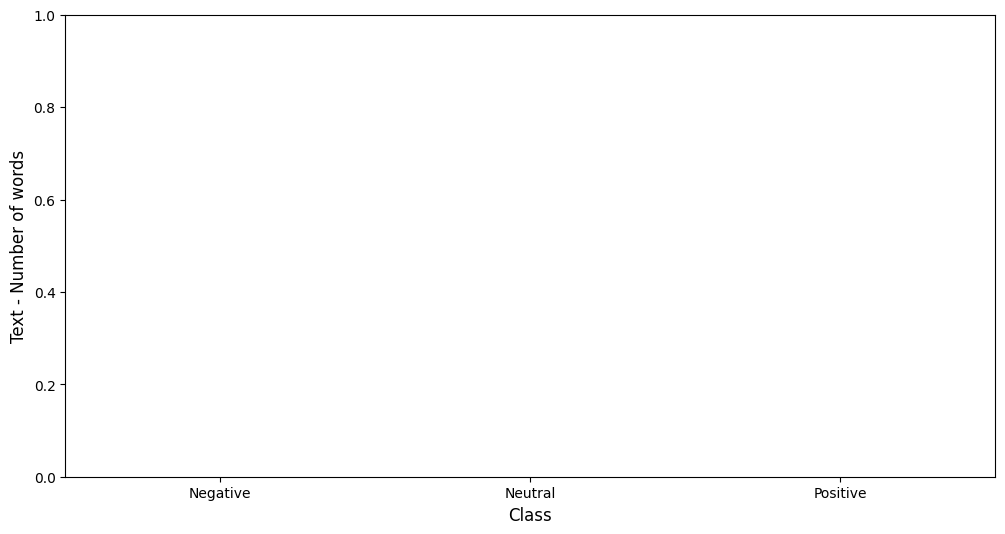

In [ ]:
def plot_freq_class(x, y):
    num_words = x['x'].apply(count_words)
    #print(num_words)
    one_word_lines = num_words[num_words == 1]

    # print the count of one-word lines
    print("Number of one-word lines: ", len(one_word_lines))

    merged_df = pd.DataFrame({'Word Count': num_words, 'Sentiment': y})
    print(merged_df)
    plt.figure(figsize=(12,6))
    sns.boxplot(data=merged_df, x='Sentiment', y='Word Count', order=senti_categories)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Text - Number of words', fontsize=12)
    plt.show()

print(type(x_train), type(y_train))
plot_freq_class(x_train, y_train)